# Condensation and Coagulation
Homework 2 for the course Aerosols physics and chemistry

# Libraries

In [33]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyfluids import Fluid, FluidsList, Input
from scipy import constants as const
import pandas as pd

mpl.rcParams["figure.dpi"] = 100

# Global constants

In [34]:
h = const.Planck  # J s Planck constant
r_gas_c = const.R  # J/(mol K) molar gas constant 
k_boltz = const.Boltzmann  # J/K Boltzmann constant
g = const.g  # m/s^2 acceleration due to gravity
n_avo = const.Avogadro  # 1/mol Avogadro's number

# Function Definitions

In [35]:
# Default air standard properties
pressure_std = 101325 # Pa
temperature_std = 273.15 + 25 # K #??????? need to make sure this is the right temperature
air_std = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temperature_std-273.15))

def c_cunningham(d_p, lamda = 65E-9):
    #defining the function
    #Cunningham correction factor
    #Dp is the particle diameter in meters
    #lamda is the mean free path of the gas in meters
    #C is the Cunningham correction factor
    kn = 2 * lamda / d_p
    return 1 + kn * (1.257 + 0.4 * np.exp(-1.1 / kn))
    
    
def mean_free_path(temperature, pressure):
# mean free path of air calculator
#T is the temperature in Kelvin
#P is the pressure in Pascals
#lamda is the mean free path of the gas in meters
    R = 8.314 # J/(mol K) gas constant
    M = 0.0289647 # kg/mol molar mass of air
    air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
    viscosity = air.dynamic_viscosity # Pa s dynamic viscosity
    return 2 * viscosity / (pressure * np.sqrt(8 * M / (np.pi * R * temperature)))


def reynolds_number(d_p, velocity, fluid_density = air_std.density, dynamic_viscosity = air_std.dynamic_viscosity):
    #Reynolds number calculator
    #Dp is the particle diameter in meters
    #rho_f is the density of the fluid in kg/m^3
    #g is the acceleration due to gravity in m/s^2
    #C is the Cunningham correction factor
    #Re is the Reynolds number
    return (d_p * fluid_density * velocity) / dynamic_viscosity


def settling_velocity(d_p, rho_p, temperature, pressure):
    # Check if Dp_input is an array or a single value
    if np.isscalar(d_p):
        d_p_array = np.array([d_p])  # Convert to array for uniform processing
    else:
        d_p_array = d_p  # Use the array as is

    velocities = []  # Empty list to store calculated velocities
    for d_p in d_p_array:  # Process each Dp individually
        g = 9.81  # m/s^2
        l_mfp = mean_free_path(temperature, pressure)
        c_cun = c_cunningham(d_p, l_mfp)
        air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
        mu_f = air.dynamic_viscosity
        rho_f = air.density
        s_velocity = c_cun * (rho_p * g * d_p**2) / (18 * mu_f)  # Stokes settling velocity
        Re = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
        if Re < 1:
            velocities.append(s_velocity)
        else:
            # Adjusted iterative approach for Re > 1, similar to before
            m_p = np.pi * rho_p * d_p**3 / 6
            for i in range(100):
                # c_d = 24 / Re * (1 + 0.15 * Re**(0.687))  # Updated drag coefficient expression
                c_d = 24 / Re * (1 + 3/16 * 0.43 * Re)
                # s_velocity = np.sqrt((4 * m_p * g) / (3 * np.pi * c_d * rho_f * Dp**2))
                s_velocity = np.sqrt((m_p * g) / (1/8 * np.pi * c_d * rho_f * d_p**2))
                Re_new = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
                if abs(Re_new - Re) < 0.01:
                    break  # Exit the loop if the change in Reynolds number is small enough
                else:
                    Re = Re_new
            velocities.append(s_velocity)

    velocities_array = np.array(velocities)  # Convert list to array

    if np.isscalar(d_p):
        return velocities_array[0]  # Return a single value if input was scalar
    else:
        return velocities_array  # Return array if input was array
    
def cond_dia_growth_rate(d_p, c_inf, c_sat, diff_coefficient, rho_p = 1E3):
    #condensation diameter growth rate
    #Dp is the particle diameter in meters
    b_factor = beta_corr_cond(d_p)
    d_dp_dt = b_factor * 4 * diff_coefficient * (c_inf - c_sat) / (rho_p * d_p)
    return d_dp_dt
    # # if np.isscalar(d_p):
    # #     d_p_array = np.array([d_p])  # Convert to array for uniform processing
    # # else:   
    # #     d_p_array = d_p  # Use the array as is
    # # dia_growth_rate = []  # Empty list to store calculated velocities
    # 
    # return dia_growth_rate


def cond_mass_growth_rate(d_p, c_inf, c_sat, diff_coefficient_vapor, rho_p = 1E3): 
    #condensation mass growth rate
    #Dp is the particle diameter in meters
    #c_inf is the concentration of the condensing vapor in the bulk gas in molec/m^3
    #c_sat is the saturation concentration of the condensing vapor in molec/m^3
    #diff_coefficient is the diffusion coefficient of the condensing vapor in m^2/s
    #rho_p is the density of the particle in kg/m^3 (default is 1E3 kg/m^3)
    #m_p is the mass of the particle in kg
    #particle mass
    # J is the same as condensation mass growth rate
    j_coag_calculated = 2 * np.pi * diff_coefficient_vapor * d_p * (c_inf - c_sat) * beta_corr_cond(d_p) #kg/s
    return j_coag_calculated


def beta_corr_cond(d_p, lamda = 65E-9):
    #Dahneke correction factor
    #Dp is the particle diameter in meters
    #B is the Darkener correction factor
    # kn is the Knudsen number
    # lamda is the mean free path of the gas in meters
    kn = 2 * lamda / d_p
    b_factor = (1 + kn) / (1 + 2 * kn * (1 + kn))
    return b_factor


def unit_conversion(conversion, variable=1):
    switcher = {
        #length
        'cm3_to_m3': variable * 1E-6,
        'm3_to_cm3': variable * 1E6,
        #time
        'hr_to_s': variable * 3600,
        's_to_hr': variable * 1/3600,
        #volume
        'm3_to_L': variable * 1000,
        'L_to_m3': variable * 1/1000,
        #mass
        'kg_to_g': variable * 1000,
        'g_to_kg': variable * 1/1000,
        'kg_to_ug': variable * 1E9,
        'ug_to_kg': variable * 1E-9,
        
        #pressure
        'Pa_to_kPa': variable * 1E-3,
        'kPa_to_Pa': variable * 1E3,
        'atm_to_Pa': variable * 101325,
        'Pa_to_atm': variable * 1/101325,
        #temperature
        'C_to_K': variable + 273.15,
        'K_to_C': variable - 273.15,
        
    }
    return switcher.get(conversion, 'Invalid conversion')


def dp_to_mp_distribution(d_p, rho_p = 1E3):
    #Dp is the particle diameter in meters
    #rho_p is the density of the particle in kg/m^3
    #m_p is the mass of the particle in kg
    m_p = np.pi * rho_p * d_p**3 / 6
    return m_p


def vol_sphere(d_p):
    #Dp is the particle diameter in meters
    #V is the volume of the sphere in m^3
    return (4/3) * np.pi * (d_p/2)**3


def surf_sphere(d_p):
    #Dp is the particle diameter in meters
    #A is the surface area of the sphere in m^2
    return 4 * np.pi * (d_p/2)**2

# Other Functions - Coagulation

In [36]:
def k_coag(d_p_1, d_p_2, temp = temperature_std, rho_1 = 1000, rho_2 = 1000): #
    # Source: Sienfeld, J. H., & Pandis, S. N. (2006). Atmospheric chemistry and physics: from air pollution to climate change. John Wiley & Sons.
    # 2nd Edition Table 13.1
    #coagulation coefficient
    #Dp1 is the diameter of particle 1 in meters
    #Dp2 is the diameter of particle 2 in meters
    #c1 is the concentration of particle 1 in molec/m^3
    #c2 is the concentration of particle 2 in molec/m^3
    #d_diff1 is the diffusion coefficient of particle 1 in m^2/s
    #d_diff2 is the diffusion coefficient of particle 2 in m^2/s
    #temp is the temperature in Kelvin
    #rho_1 is the density of particle 1 in kg/m^3
    #rho_2 is the density of particle 2 in kg/m^3
    # k_bolt is the Boltzmann constant in J/K defined in the global constants
    
    # Convert dp_1 and dp_2 to numpy arrays if they are not already
    dp_1_np = np.array([d_p_1])
    dp_2_np = np.array([d_p_2])

    #k is the coagulation coefficient
    # used the mass of a particle because the c_1 and c_2 are velocity of the particles
    air_01 = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temp-273.15))
    vis_air = air_01.dynamic_viscosity # Pa s dynamic viscosity
    d_diff1 = k_boltz * temp * np.array([c_cunningham(dp) for dp in dp_1_np]) / (3 * np.pi * vis_air * dp_1_np)
    d_diff2 = k_boltz * temp * np.array([c_cunningham(dp) for dp in dp_2_np]) / (3 * np.pi * vis_air * dp_2_np)
    m_1 = rho_1 * np.pi * dp_1_np ** 3 / 6  # mass of one particle in kg 
    m_2 = rho_2 * np.pi * dp_2_np ** 3 / 6  # mass of one particle in kg
    c_1 = np.sqrt(8 * k_boltz * temp / (np.pi * m_1))
    c_2 = np.sqrt(8 * k_boltz * temp / (np.pi * m_2))
    l_1 = 8 * d_diff1 / (np.pi * c_1)
    l_2 = 8 * d_diff2 / (np.pi * c_1)
    g_1 = 1 / (3 * dp_1_np * l_1) * ((dp_1_np + l_1) ** 3 - (dp_1_np ** 2 + l_1 ** 2) ** (3 / 2)) - dp_1_np
    g_2 = 1 / (3 * dp_2_np * l_2) * ((dp_2_np + l_2) ** 3 - (dp_2_np ** 2 + l_2 ** 2) ** (3 / 2)) - dp_2_np
    denominator = (((dp_1_np + dp_2_np) / (dp_1_np+dp_2_np+2*np.sqrt(g_1**2+g_2**2))) + 8*(d_diff1+ d_diff2)/(c_1**2+c_2**2)**0.5 / (dp_1_np+dp_2_np))
    
    k_coag_fuchs = 2 * np.pi * (dp_1_np + dp_2_np) * (d_diff1 + d_diff2) / denominator             
    return k_coag_fuchs

# Bins definition

In [37]:
#defining the bins
bin_number = 40
bins_lower = np.geomspace(1e-9, 10.3e-6, bin_number + 1)  #
bins_upper = bins_lower[1:]
bins_lower = bins_lower[:-1]
bins_g_mean = np.sqrt(bins_lower * bins_upper)  # geometric mean
bins_g_mean_mass = dp_to_mp_distribution(bins_g_mean)

# Problem 1
Condensation of Sulfuric Acid (H2SO4) 

In [38]:
molec_weight_H2S04 = 98.079 / 1000 #kg/mol
c_inf_h2so4 = 5E7 / const.centi ** 3 /const.Avogadro * molec_weight_H2S04 #unit conversion from molec/cm^3  kg/m^3
c_sat_h2so4 = 0 #molec/m^3
diff_h2so4 = 1E-5 #m^2/s

# Problem 1-part a
Condensation diameter growth rate

In [39]:
dp_dt_condensation = cond_dia_growth_rate(bins_g_mean, c_inf_h2so4, c_sat_h2so4, diff_h2so4, rho_p = 1E3)
dm_dt_condensation = cond_mass_growth_rate(bins_g_mean, c_inf_h2so4, c_sat_h2so4, diff_h2so4, rho_p = 1E3)

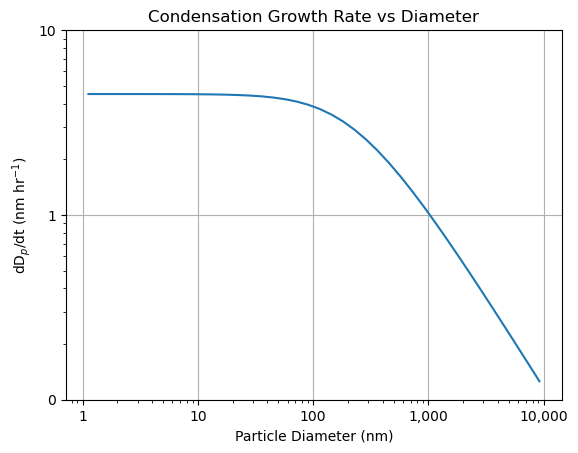

In [40]:
# plot condensation growth rate vs diameter
fig, ax = plt.subplots()
ax.plot(bins_g_mean / const.nano, dp_dt_condensation * 1e9 * 3600)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Particle Diameter (nm)')
ax.set_ylabel(r'dD$_p$/dt (nm hr$^{-1}$)')
ax.set_title('Condensation Growth Rate vs Diameter')
ax.set_ylim([1e-1, 1e1])

# change the x-axis labels to float
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax.xaxis.set_major_formatter(formatter)

# change the y-axis labels to float
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax.yaxis.set_major_formatter(formatter)

plt.grid()

fig.savefig('hw2_pr1_1_condensation_growth_rate_vs_diameter.png')
plt.show()



# Problem 1-part b
Condensation mass growth rate

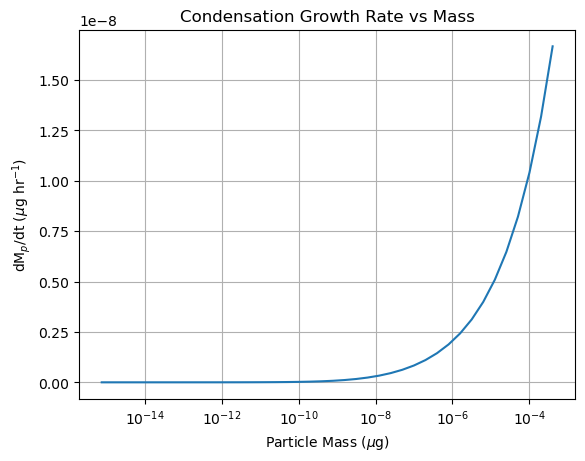

In [41]:
# plot mass growth rate vs particle mass
fig, ax = plt.subplots()
ax.plot(bins_g_mean_mass * unit_conversion('kg_to_ug'),
        dm_dt_condensation * unit_conversion('kg_to_ug') * unit_conversion('hr_to_s')) #converted to kg/s to ug/hr
#converted kg to ug
ax.set_xscale('log')
ax.set_xlabel('Particle Mass ($\mu$g)')
ax.set_ylabel(r'dM$_p$/dt ($\mu$g hr$^{-1}$)')
ax.set_title('Condensation Growth Rate vs Mass')
plt.grid()
plt.savefig('hw2_pr1_2_condensation_growth_rate_vs_mass.png')
plt.show()

# Problem 2
Coagulation as a growth mechanism


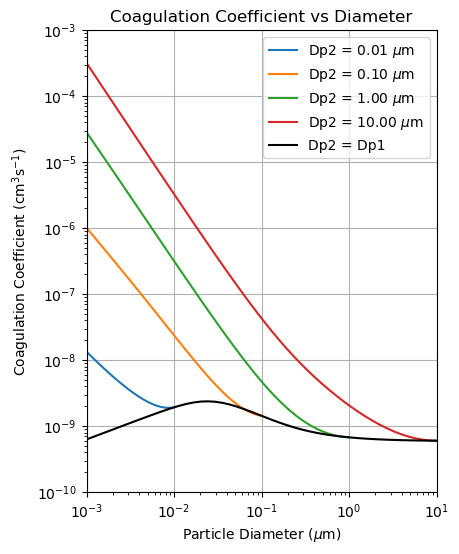

In [42]:
# plot coagulation coefficient vs particle diameter
fig, ax = plt.subplots( figsize=(5, 6))

for dp_2 in np.geomspace(1e-8, 1e-5, 4):
    dp_1 = np.geomspace(1e-9, dp_2, 50)
    k_c = k_coag(dp_1, dp_2).flatten()  # Flatten the array to make it 1D
    ax.plot(dp_1 / const.micro, k_c / const.centi ** 3, label=f'Dp2 = {dp_2 / const.micro:.2f} $\mu$m')
    
dp_same = np.geomspace(1e-9, 1e-5, 50)
k_c = k_coag(dp_same, dp_same).flatten()
ax.plot(dp_same / const.micro, k_c / const.centi ** 3, label=f'Dp2 = Dp1', color='black')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'Particle Diameter ($\mu$m)')
ax.set_ylabel(r'Coagulation Coefficient (cm$^3$s$^{-1}$)')
plt.grid()
ax.set_title('Coagulation Coefficient vs Diameter')
ax.set_xlim([1e-3, 10])  # Set the limits of x-axis
ax.set_ylim([1e-10, 1e-3])  # Set the limits of y-axis
ax.legend()

# Adjust the space on the left side of the plot
plt.subplots_adjust(left=0.2)

plt.savefig('hw2_pr2_1_coagulation_coefficient_vs_diameter.png')
plt.show()

In [43]:
# making a table of the coagulation coefficient
dp_2 = [2e-9, 1e-8, 1e-7, 1e-6, 1e-5, 2e-5]
dp_1 = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 2e-5]
k_c = np.array([[k_coag(d1, d2) for d1 in dp_1] for d2 in dp_2])
# print in the table format pandas dp2 as the index and dp1 as the columns 
k_c_squeezed = np.squeeze(k_c, axis=-1)  # Squeeze the array along the last axis
df = pd.DataFrame(k_c_squeezed /const.centi**3, index = dp_2, columns = dp_1)

In [44]:
N1 = 3000 / const.centi ** 3 #particle/m^3
dp1 = 10 * const.nano #m
N2 = 400 / const.centi ** 3 #particle/m^3
dp2 = 100 * const.nano #m
rho_1 = rho_2 = 1E3 #kg/m^3
j_coag = k_coag(dp1, dp2) * N1 * N2 #collision/m^3/s
print(f'{k_coag(dp1, dp2)[0] / const.centi ** 3:.2e} cm^3/s') # Convert coagulation coefficient from m^3/s to cm^3/s
print(f'{j_coag[0] * const.centi ** 3:.2e} collision/cm^3/s') # Convert collision/m^3 /s to collision/cm^3 s
# converted m^3/s to cm^3/s

2.38e-08 cm^3/s
2.85e-02 collision/cm^3/s


In [45]:
# frequency of collisions with particles
freq_coll = k_coag(dp1, dp2)[0] * N1 #collision/s
print(f' frequency of collisions with smaller particles: {freq_coll:.2e} collision/s')

#delete this
# one_N2_particles_surface = np.pi * dp2 ** 2 / 4  #m^2/particle
# all_N2_particles_surface = one_N2_particles_surface * N2 #m^2/m^3
# freq_coll = j_coag * all_N2_particles_surface

 frequency of collisions with smaller particles: 7.13e-05 collision/s


In [46]:
# growth rate of the larger particles
volume_of_dp1 = vol_sphere(dp1)  #m^3
mass_growth_rate_dp2_coag = freq_coll * volume_of_dp1 #m^3/s
dia_growth_rate_dp2_coag = mass_growth_rate_dp2_coag * (2/ np.pi / dp2**2) #m/s
dia_growth_rate_dp2_coag_nm__hr = dia_growth_rate_dp2_coag / const.nano * 3600 #nm/hr
mass_growth_rate_dp2_coag_kg__hr = mass_growth_rate_dp2_coag * 3600 #kg/hr
print(f'Growth rate of the larger particles: {dia_growth_rate_dp2_coag_nm__hr:.2e} nm/hr')

Growth rate of the larger particles: 8.56e-03 nm/hr


In [47]:
# Total growth after 1 week
total_growth_dia = dia_growth_rate_dp2_coag_nm__hr * 24 * 7 #nm
percent_growth_dia = total_growth_dia / (dp2 / const.nano) * 100
total_growth_mass = mass_growth_rate_dp2_coag_kg__hr * 24 * 7 #kg
percent_growth_mass = total_growth_mass / (vol_sphere(dp2)) * 100

print(f'Total growth in diameter after 1 week: {total_growth_dia:.2f} nm')
print(f'Percent growth in diameter after 1 week: {percent_growth_dia:.2f} %')
print(f'Total growth in mass after 1 week: {total_growth_mass:.2e} kg')
print(f'Percent growth in mass after 1 week: {percent_growth_mass:.4f} %')


Total growth in diameter after 1 week: 1.44 nm
Percent growth in diameter after 1 week: 1.44 %
Total growth in mass after 1 week: 2.26e-23 kg
Percent growth in mass after 1 week: 4.3122 %
